In [1]:
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import os
import torch
from torchvision import models
import clip
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import time
import copy
from collections import defaultdict
import torch, time, copy
from torch.amp import autocast

In [19]:
# check dataset
gt_file = Path("devkit-1.0/data/ILSVRC2010_validation_ground_truth.txt")
gt = [int(x) for x in gt_file.read_text().split()]
demo_dir = Path("/home2/aryan.g/assignment-5-aryangupta110/q3/val")   
val_paths = sorted(demo_dir.glob("*.JPEG"))
for p in tqdm(val_paths):
    try:
        with Image.open(p) as img:
            img.load()   
    except (OSError, IOError):
        print(f"Corrupted image found and deleted: {p}")
        os.remove(p)


100%|██████████| 1578/1578 [00:07<00:00, 201.34it/s]


In [ ]:
#  Model loading and architecture, CLIP vs ImageNet-Pretrained ResNet-50
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
resnet50.eval()
clip_model, preprocess = clip.load("RN50", device=device, jit=False)
clip_visual = clip_model.visual
clip_model.eval()
print("=== torchvision ResNet-50 ==="); print(resnet50)
print("\n=== CLIP Visual Encoder (RN50) ==="); print(clip_visual)

=== torchvision ResNet-50 ===
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, k

### Do the visual encoders have the same architecture?

No, the visual encoders used in torchvision's ImageNet-pretrained ResNet-50 and OpenAI’s CLIP (ResNet-50) do **not** have the same architecture. While both are based on the general ResNet-50 backbone, CLIP introduces several **key architectural modifications** tailored for multimodal contrastive learning between images and text.

---

### Key Differences Between torchvision ResNet-50 and CLIP ResNet-50

| Feature / Component                 | **Torchvision ResNet-50**                            | **CLIP ResNet-50 (ModifiedResNet)**                |
|-----------------------------------|------------------------------------------------------|----------------------------------------------------|
| **Initial Conv Layer**            | `7x7 conv, stride=2`                                 | **Three stacked 3x3 convs**, first with `stride=2` |
| **Initial Channels**              | 3 → 64 directly                                       | 3 → 32 → 32 → 64                                    |
| **Pooling Before Layer1**         | `MaxPool2d(kernel=3, stride=2)`                      | **AvgPool2d(kernel=2, stride=2)**                  |
| **Bottleneck Blocks**             | Standard ResNet blocks                               | Bottlenecks with **custom avgpool branches**       |
| **Intermediate Pooling in Blocks**| None                                                 | **Custom avgpools** and **Identity layers**        |
| **Attention Pooling**             | Final `AdaptiveAvgPool2d + FC`                       | **AttentionPool2d** replaces global avgpool        |
| **Final Projection Layer**        | Linear(2048 → 1000 classes)                          | **Linear(2048 → 1024)** (for embedding into CLIP space) |
| **Output Role**                   | Classification logits                                | Embeddings for contrastive learning with text      |

---

### Explanation of Modifications

1. **Patchified Conv Stem**: CLIP replaces the standard `7x7` convolution with three `3x3` convolutions to reduce spatial resolution while preserving more low-level information.

2. **AvgPooling Instead of MaxPooling**: CLIP uses average pooling throughout to reduce spatial resolution more gently, likely for preserving fine-grained visual information useful for text-image alignment.

3. **Custom Residual Paths**: CLIP's residual blocks incorporate `AvgPool2d` downsampling and sometimes additional pooling layers to control the feature map sizes explicitly.

4. **Attention Pooling (attnpool)**: At the end of the CLIP visual encoder, global average pooling is replaced with a learnable `AttentionPool2d` layer. This allows the model to learn how to summarize spatial features into a fixed-size vector more effectively, in a way that's compatible with the text embedding space.

5. **Final Embedding**: Instead of classification logits, CLIP’s visual encoder produces a 1024-dimensional embedding meant to be compared with the output of a text encoder (e.g., a Transformer) via cosine similarity.

---

### Vision vs. Text Encoders in CLIP

- **CLIP Vision Encoder**: Modified ResNet-50 (or ViT, depending on variant) outputs a fixed-size image embedding.
- **CLIP Text Encoder**: Transformer-based encoder outputs a text embedding in the same embedding space.

These embeddings are used jointly during training with contrastive loss to align image and text representations.

---

### Conclusion

While the CLIP visual encoder is based on the ResNet-50 architecture, it includes **significant architectural modifications** that optimize it for embedding images into a shared vision-language space, rather than classification.


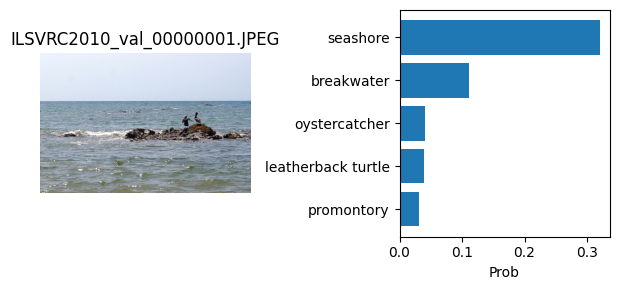

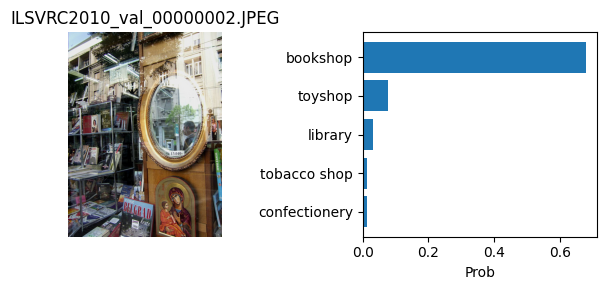

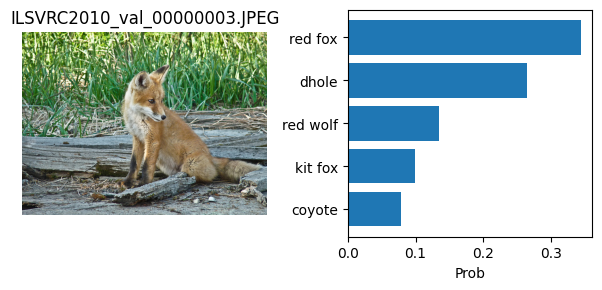

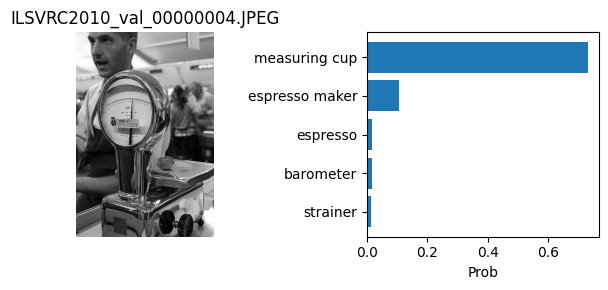

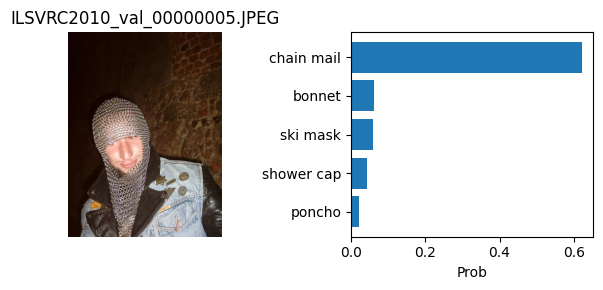

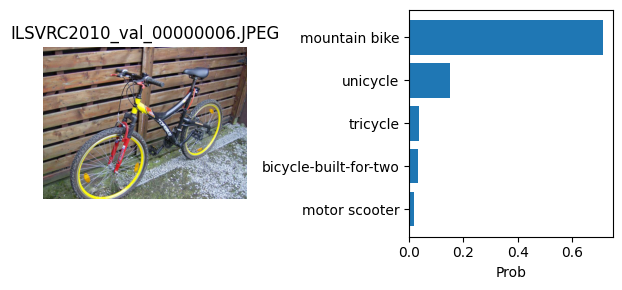

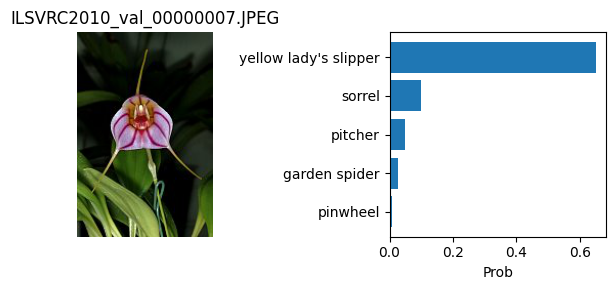

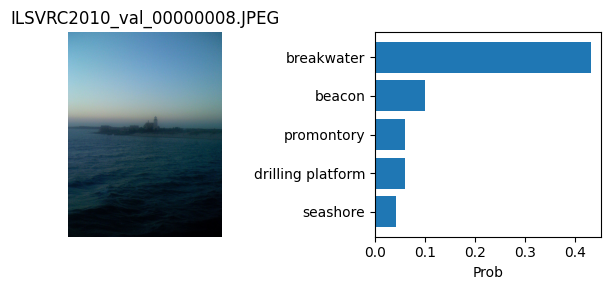

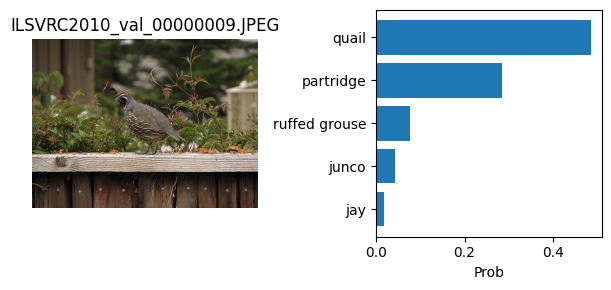

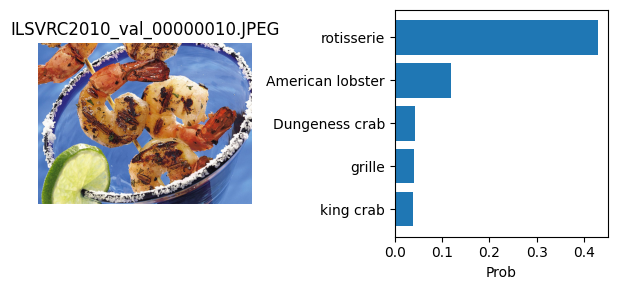

In [8]:
# Zero-Shot CLIP inference  
torch.manual_seed(0)
labels = models.ResNet50_Weights.IMAGENET1K_V1.meta["categories"]
templates = [f"a photo of a {label}." for label in labels]
text_tokens = clip.tokenize(templates).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

demo_dir = Path("./val")
imgs_paths = sorted(demo_dir.glob("*.JPEG"))[:10]
if not imgs_paths:
    print(f"Warning: no images in {demo_dir}, skipping Task 2.")
else:
    imgs = [preprocess(Image.open(p).convert("RGB")) for p in imgs_paths]
    batch = torch.stack(imgs).to(device)
    with torch.no_grad():
        feats = clip_model.encode_image(batch)
        feats /= feats.norm(dim=-1, keepdim=True)
        logits = feats @ text_features.T * clip_model.logit_scale.exp()
        probs = logits.softmax(dim=-1)
    for i,p in enumerate(imgs_paths):
        inds, vals = probs[i].topk(5).indices.cpu(), probs[i].topk(5).values.cpu()
        fig,axs = plt.subplots(1,2,figsize=(6,3))
        axs[0].imshow(Image.open(p)); axs[0].axis('off'); axs[0].set_title(p.name)
        axs[1].barh(range(5), vals); axs[1].invert_yaxis()
        axs[1].set_yticks(range(5)); axs[1].set_yticklabels([labels[j] for j in inds])
        axs[1].set_xlabel('Prob'); plt.tight_layout(); plt.show()

---


### What label hierarchy is used in ImageNet?

ImageNet uses the **WordNet** hierarchy to organize its labels. WordNet is a large lexical database of English that groups nouns, verbs, adjectives, and adverbs into sets of cognitive synonyms called **synsets** (short for "synonym sets"), each expressing a distinct concept.

In ImageNet:
- Each class label corresponds to a **WordNet synset** (e.g., `n02084071` for "dog").
- The hierarchy is structured as a **tree**, where more general concepts (like "animal") are parents of more specific ones (like "dog" or "cat").
- This allows for **semantic grouping** and hierarchy-aware tasks.

---

### What does a synset mean?

A **synset** (short for **synonym set**) is a group of words or phrases in WordNet that are interchangeable in a specific context or concept. For example:

- The synset `n02084071` includes words like "dog", "domestic dog", and "Canis familiaris".
- Each synset is identified by a unique ID and represents a **single, unambiguous concept**.

Synsets help disambiguate meaning and allow for hierarchical relationships between concepts (e.g., "dog" is a type of "canine", which is a type of "mammal").

---

### Could grouping objects based on synsets lead to problems for visual recognition?

Yes, grouping objects based solely on synsets **can lead to problems** in visual recognition due to several reasons:

1. **High Visual Diversity Within a Synset**:
   - A synset like "dog" includes many breeds with vastly different appearances (e.g., Chihuahua vs. Great Dane).

2. **Semantic but Not Visual Similarity**:
   - Words grouped semantically may not look alike visually. For instance, "keyboard" as a musical instrument vs. "keyboard" as a computer accessory may be grouped semantically but are visually very different.

3. **Ambiguity and Overlap**:
   - Some objects may belong to multiple synsets or may be mislabeled due to semantic ambiguity (e.g., "cup" vs. "mug").

---

### State 3 types of visual differences we can expect to see in images with objects corresponding to the same synset

1. **Scale and Size Variations**:
   - Objects of the same synset may appear at drastically different scales (e.g., close-up of a dog’s face vs. full-body shot).

2. **Pose and Orientation**:
   - The same object may be photographed from different angles or in different poses (e.g., a bird flying vs. perched).

3. **Appearance Diversity**:
   - Intra-class variation due to color, shape, breed, or texture differences (e.g., black Labrador vs. golden retriever both under "dog" synset).

---


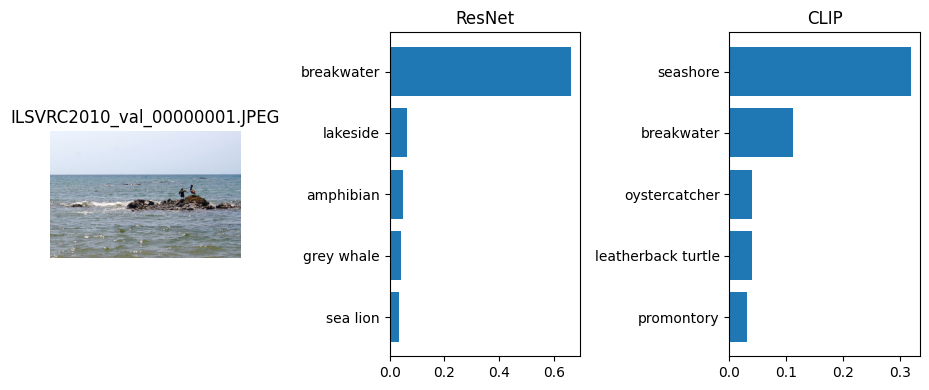

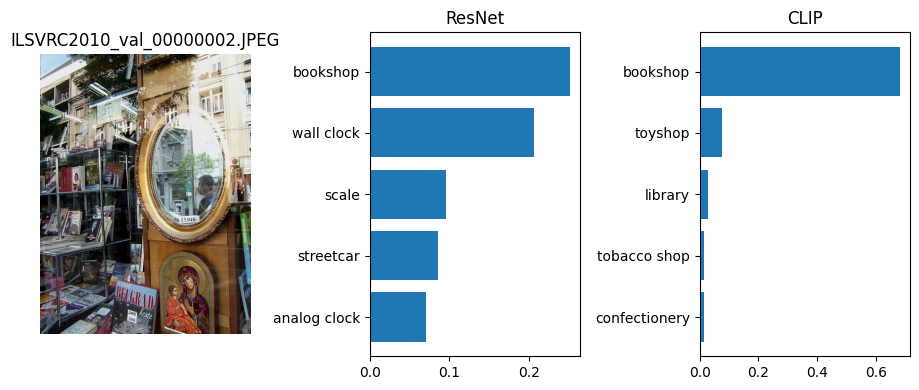

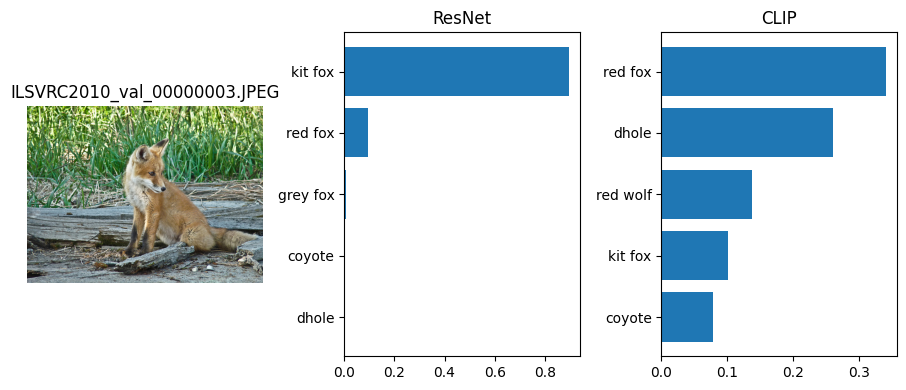

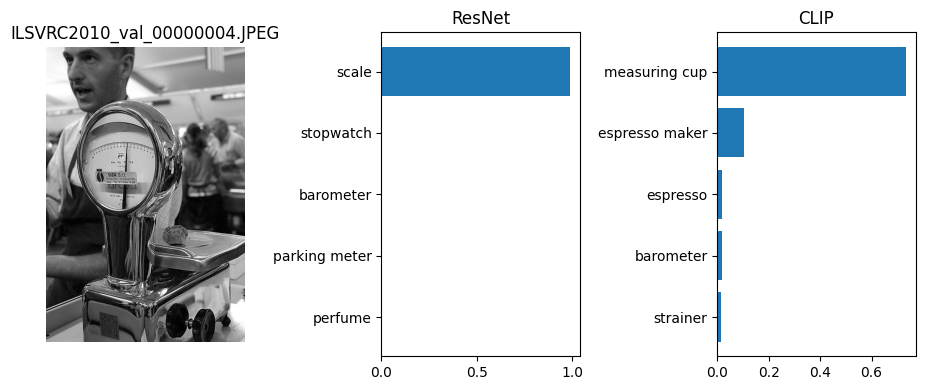

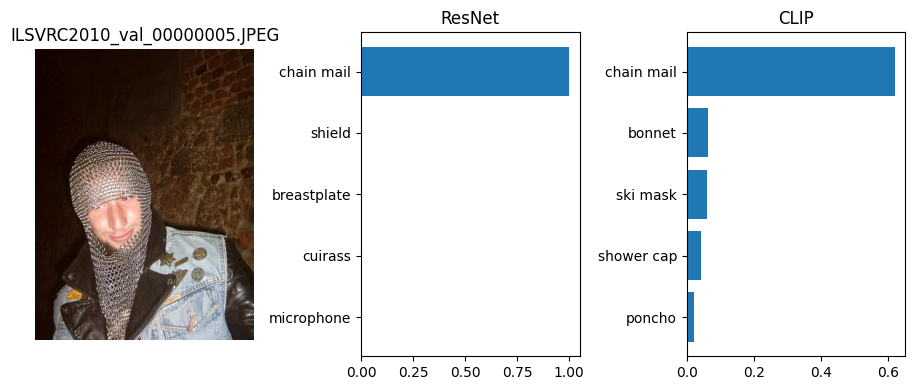

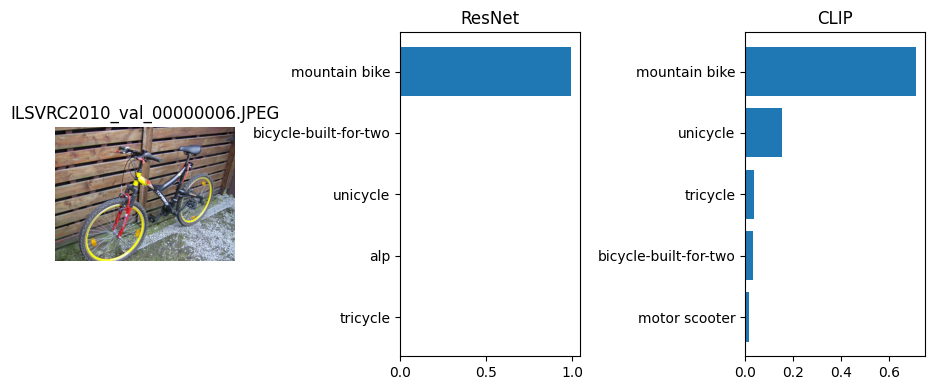

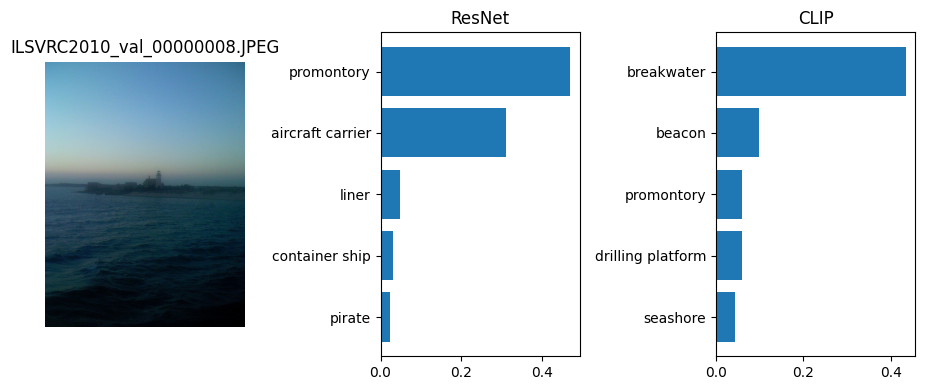

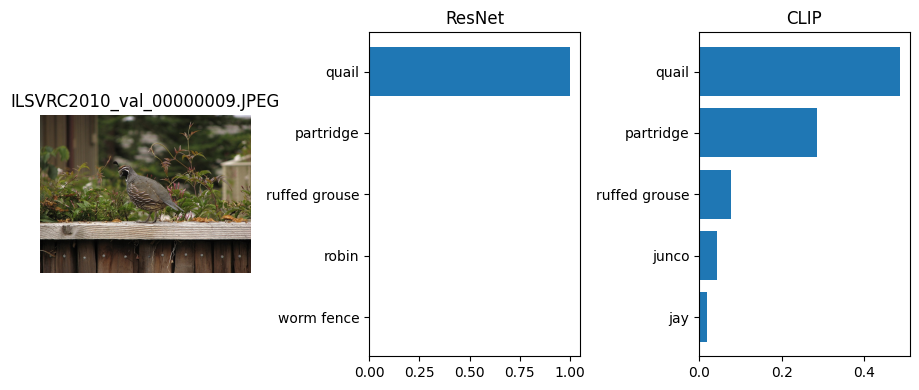

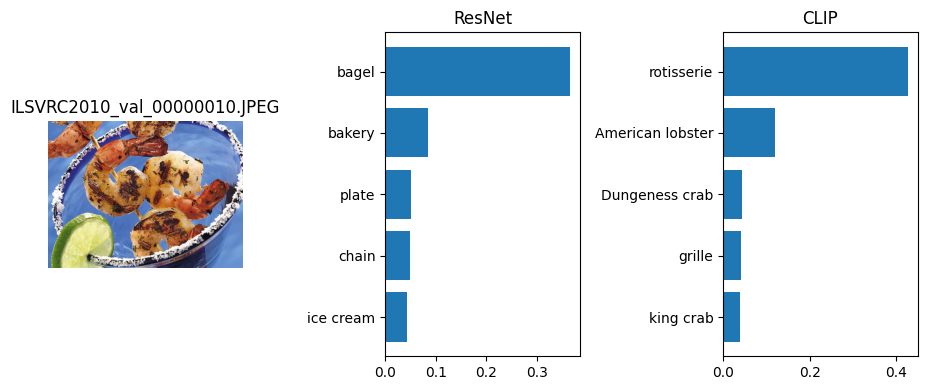

In [9]:
# Comparision ResNet-50 vs. CLIP on same images
def get_topk(model_forward, x, text_feats=None, logit_scale=None, k=5):
    with torch.no_grad():
        if text_feats is None:
            logits = model_forward(x)
        else:
            feats = model_forward(x); feats /= feats.norm(dim=-1,keepdim=True)
            logits = feats @ text_feats.T * logit_scale.exp()
        probs = logits.softmax(dim=-1)
        vals, inds = probs.topk(k,dim=-1)
    return inds[0].cpu().tolist(), vals[0].cpu().tolist()

if 'batch' in locals():
    for p,img_t in zip(imgs_paths, batch):
        x = img_t.unsqueeze(0)
        r_inds, r_vals = get_topk(resnet50, x)
        c_inds, c_vals = get_topk(clip_model.encode_image, x,
                                  text_feats=text_features, logit_scale=clip_model.logit_scale)
        fig,axs = plt.subplots(1,3,figsize=(9,4))
        axs[0].imshow(Image.open(p)); axs[0].axis('off'); axs[0].set_title(p.name)
        axs[1].barh(range(5), r_vals); axs[1].invert_yaxis()
        axs[1].set_yticks(range(5)); axs[1].set_yticklabels([labels[i] for i in r_inds])
        axs[1].set_title('ResNet')
        axs[2].barh(range(5), c_vals); axs[2].invert_yaxis()
        axs[2].set_yticks(range(5)); axs[2].set_yticklabels([labels[i] for i in c_inds])
        axs[2].set_title('CLIP')
        plt.tight_layout(); plt.show()

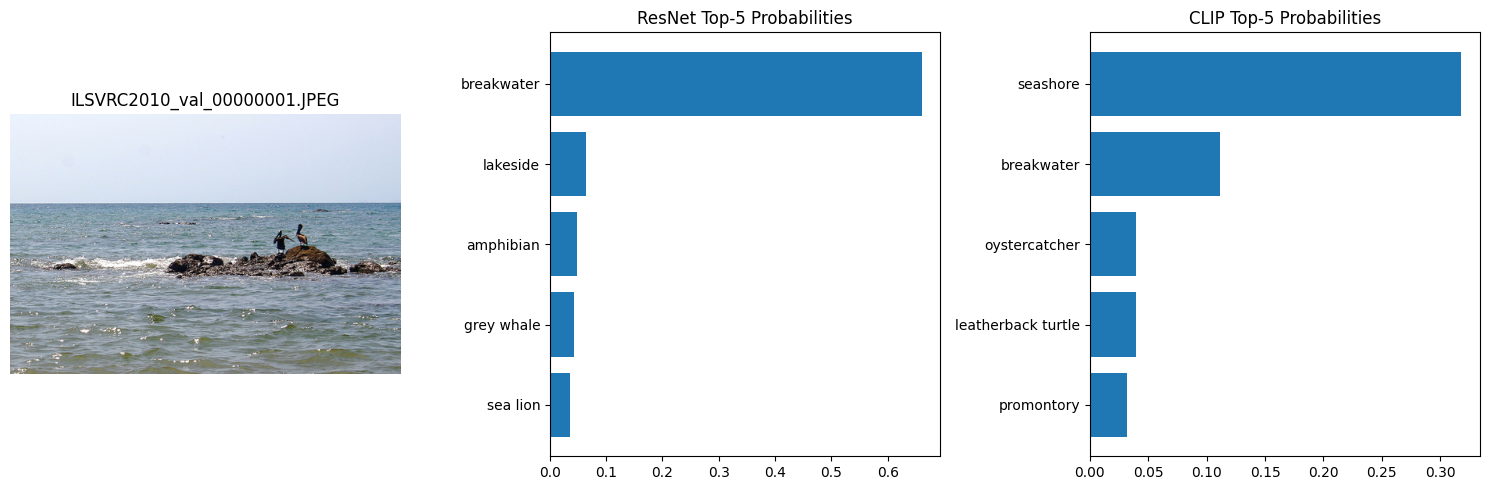

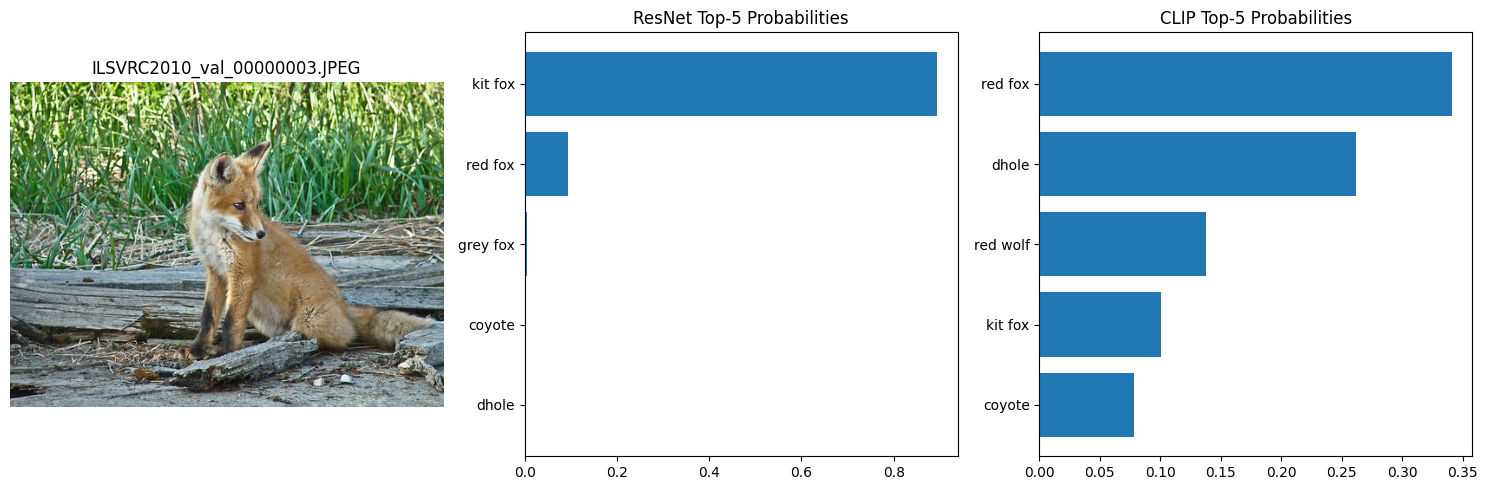

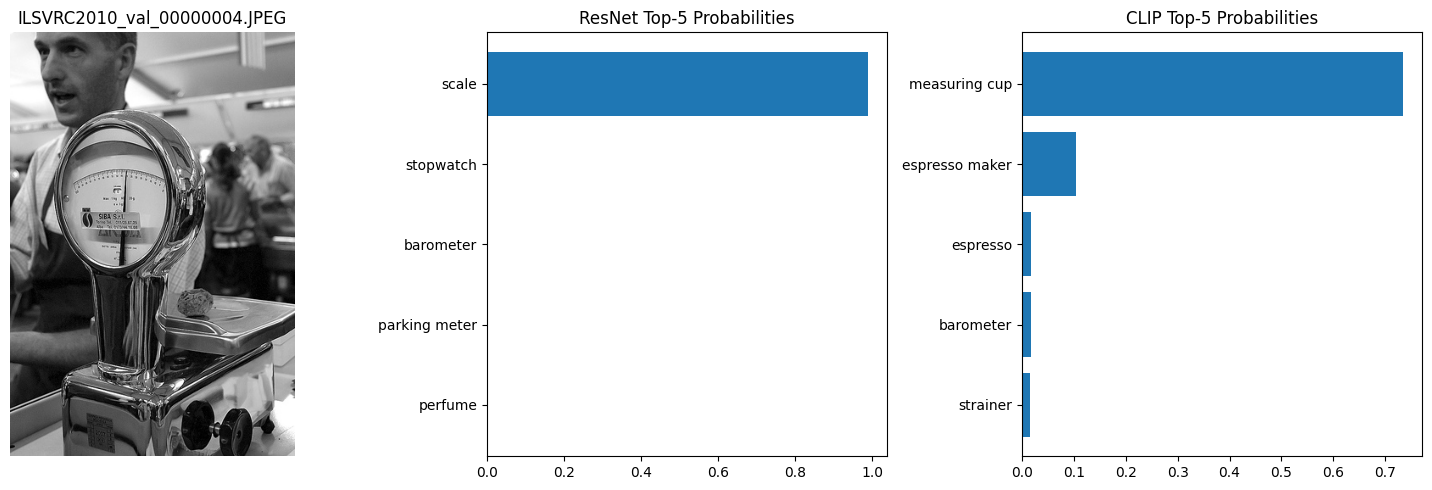

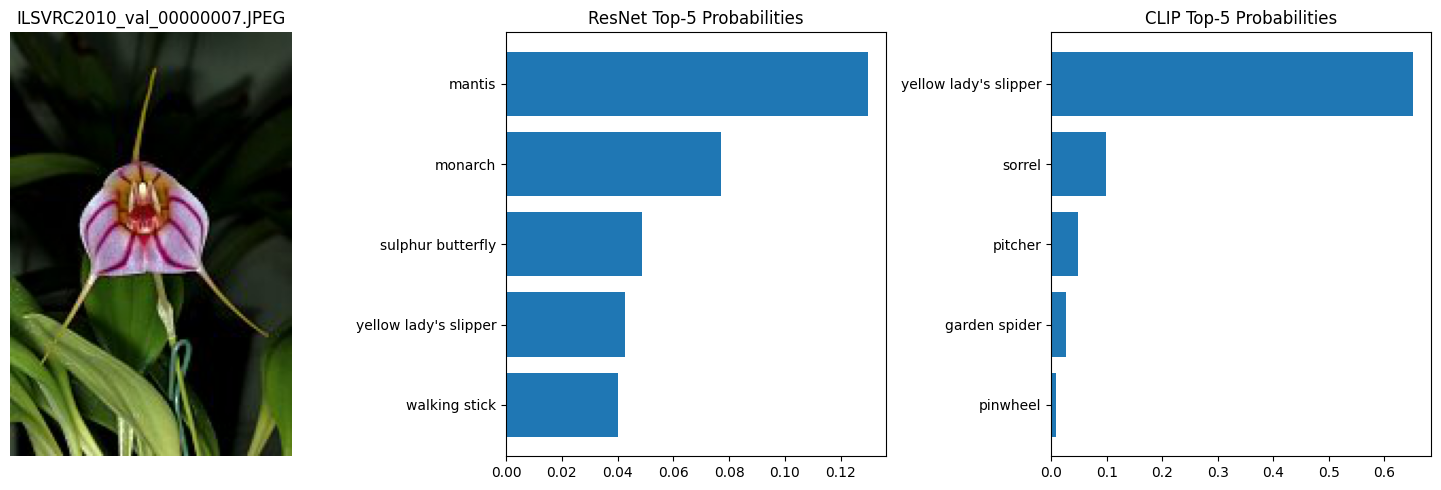

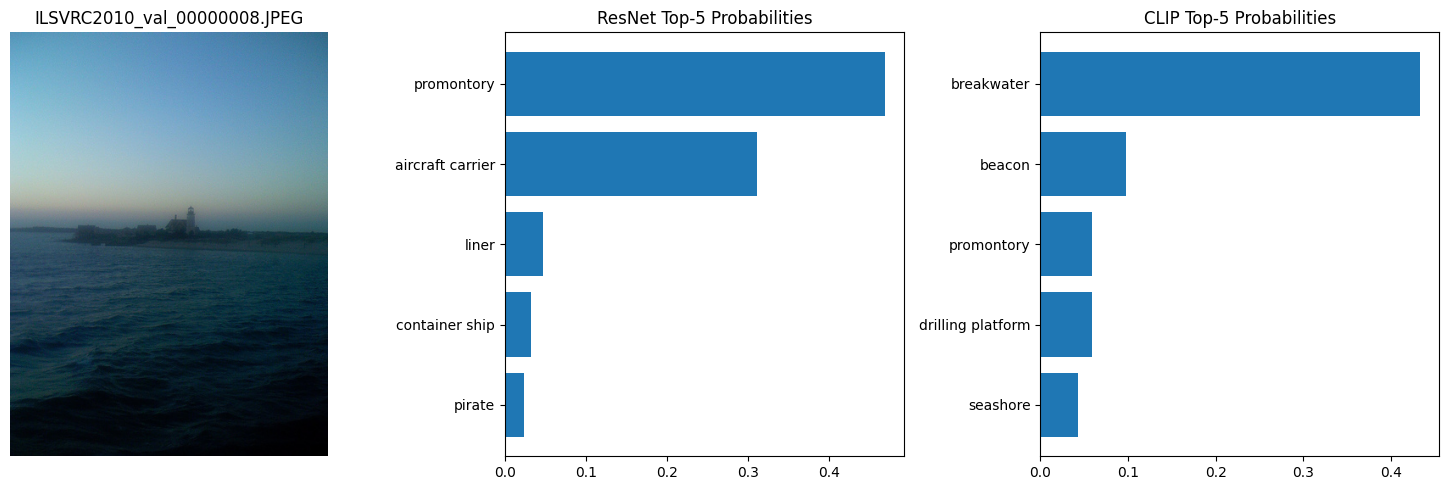

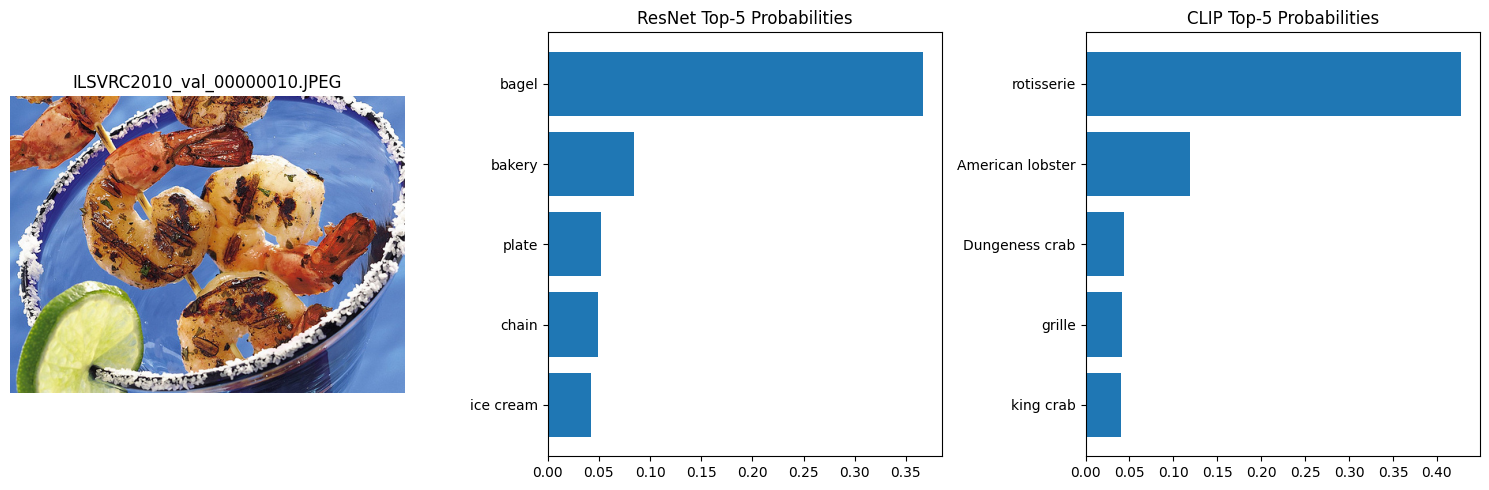

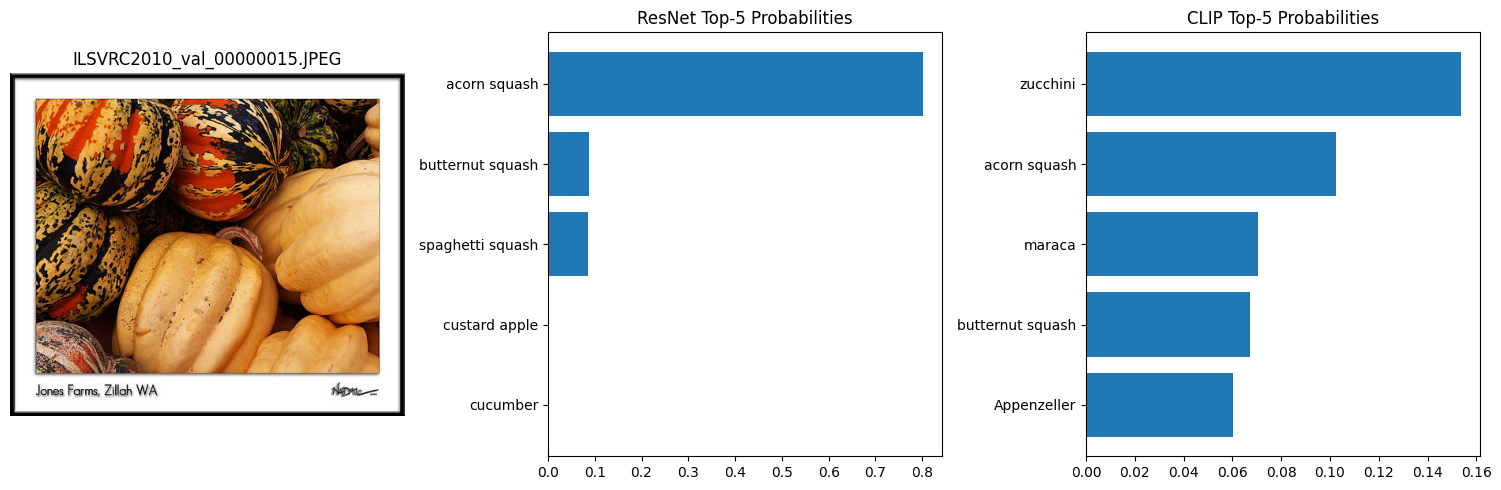

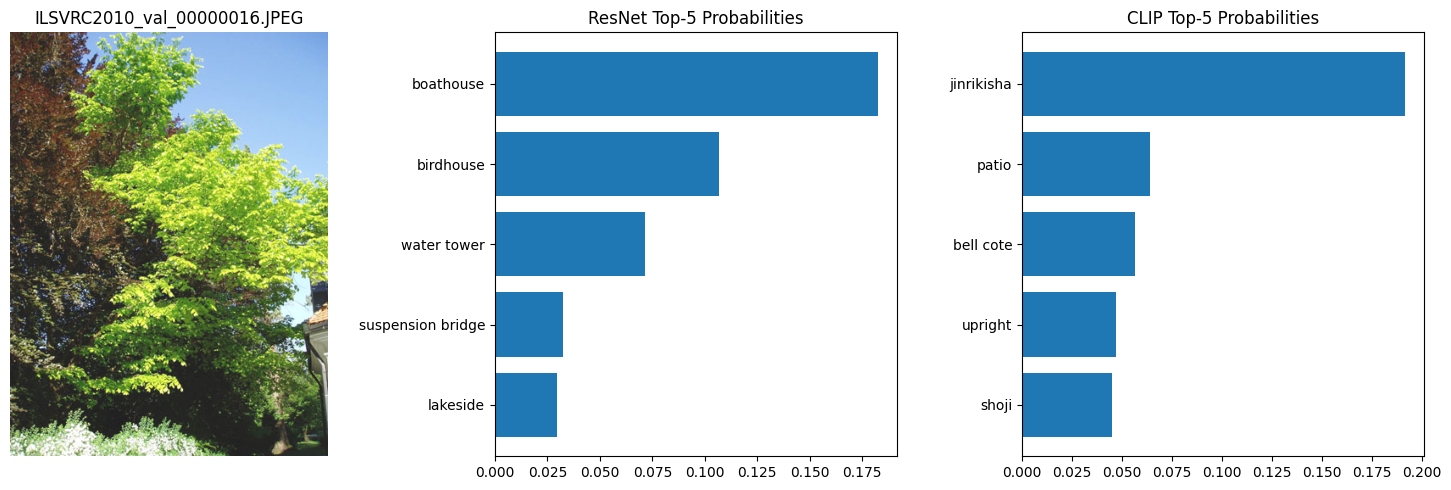

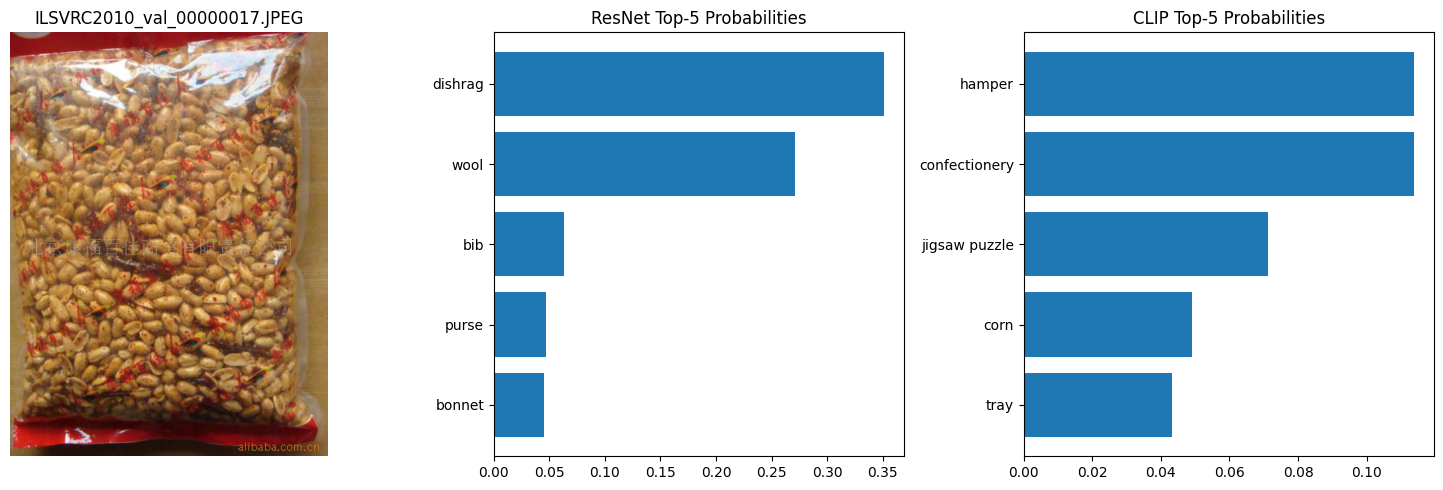

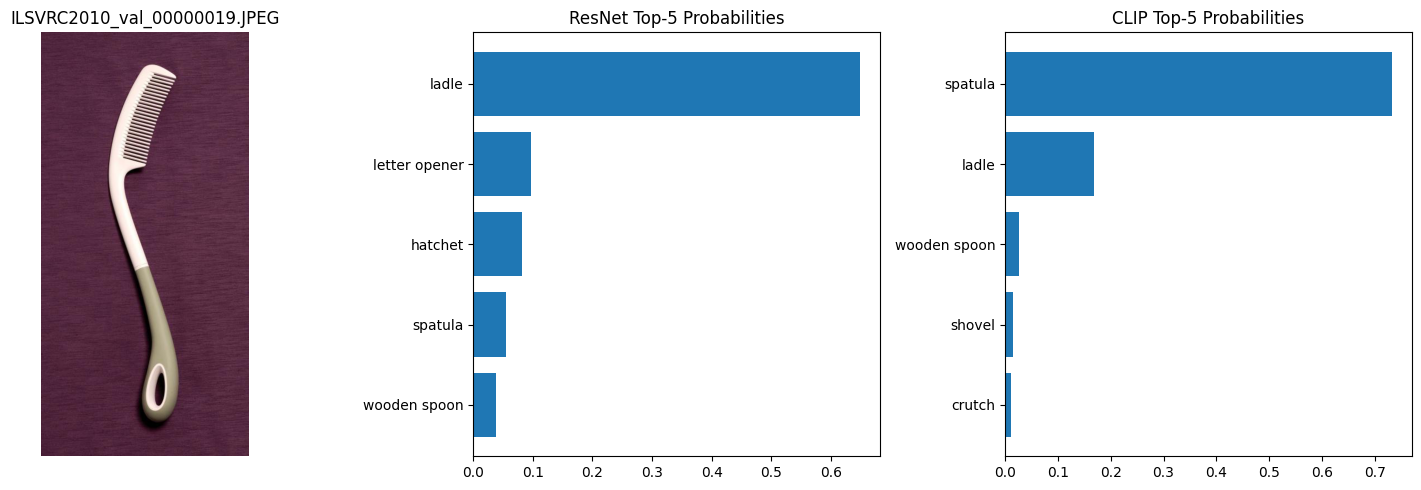

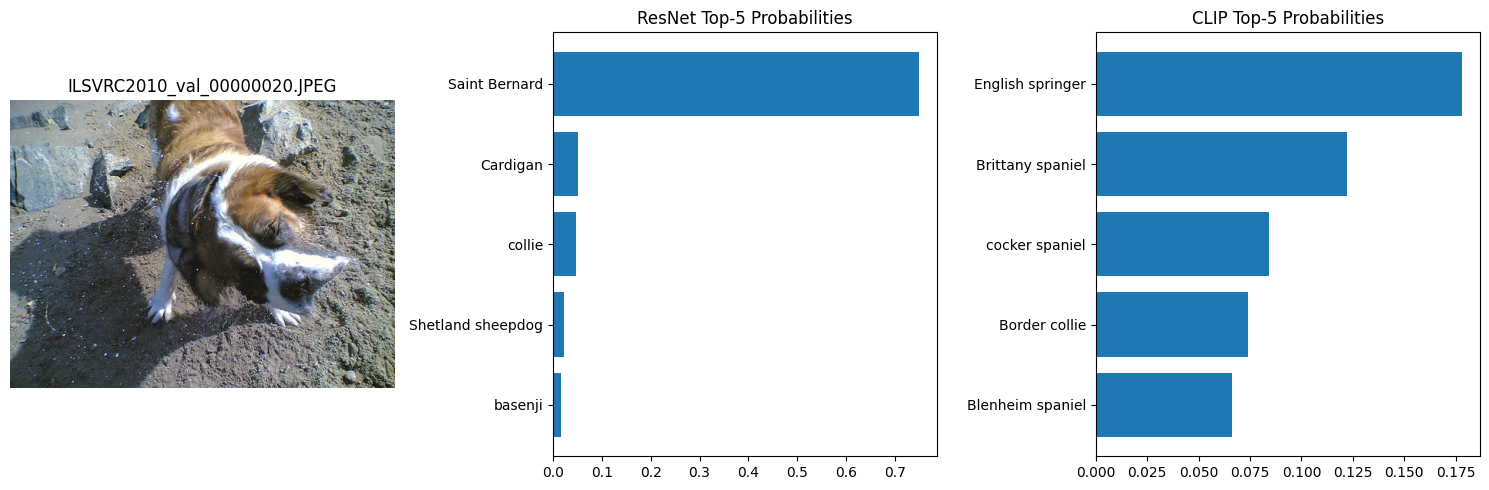

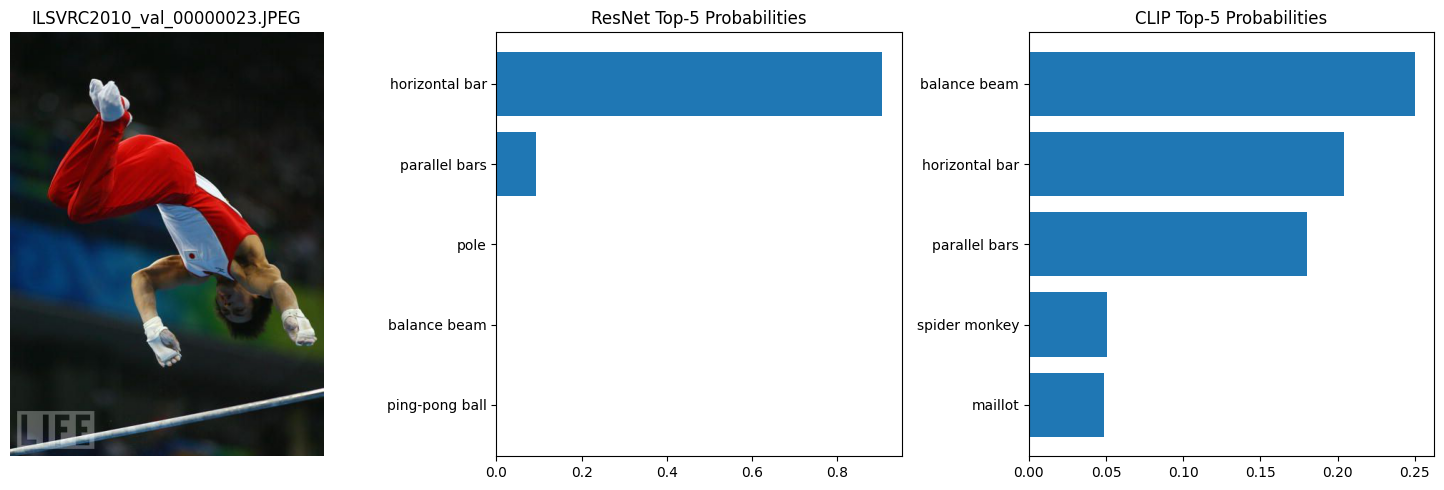

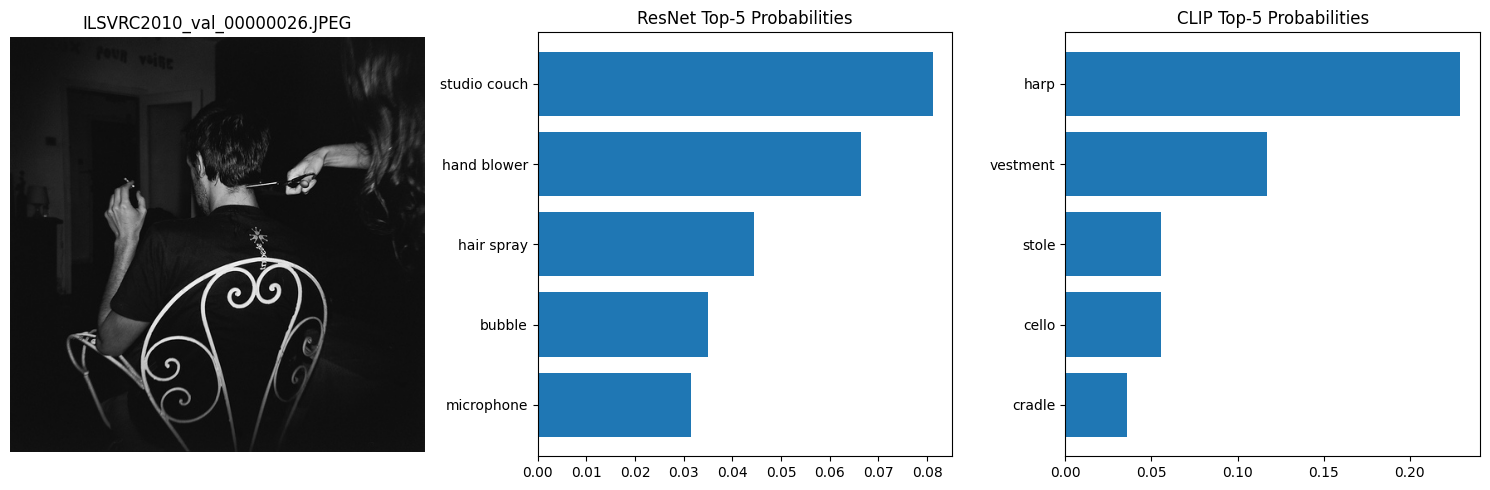

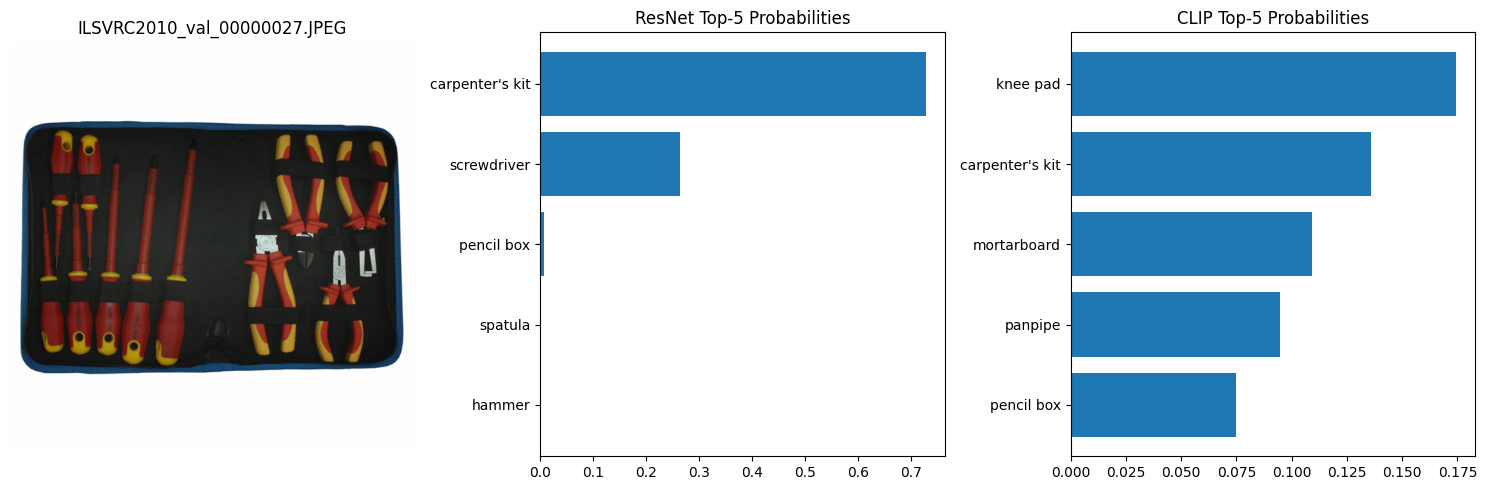

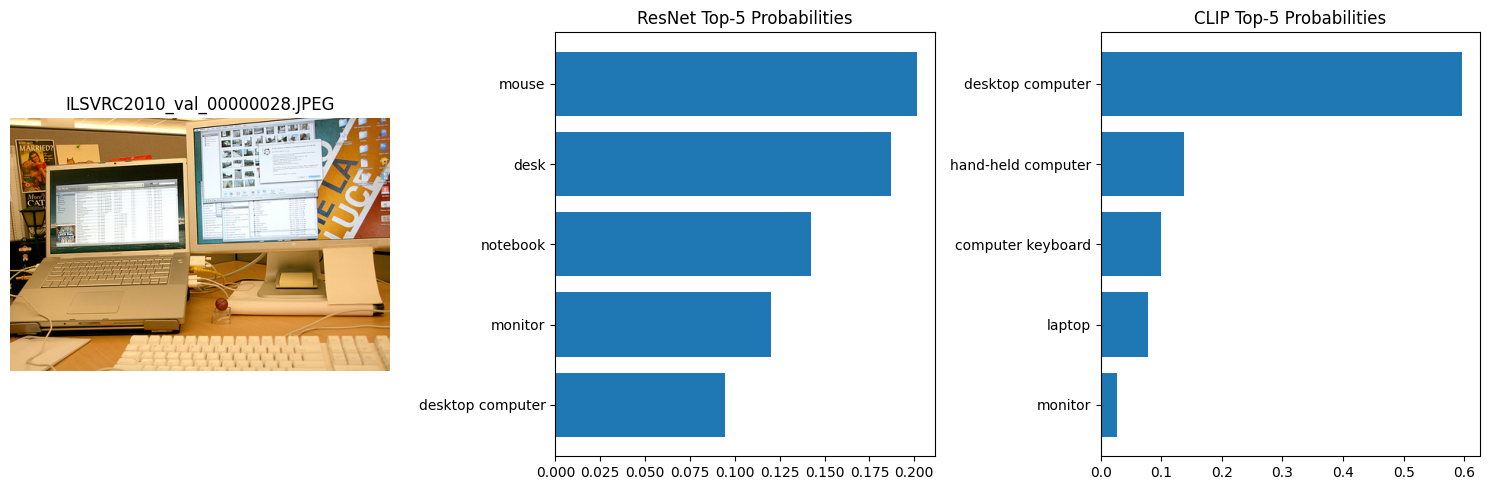

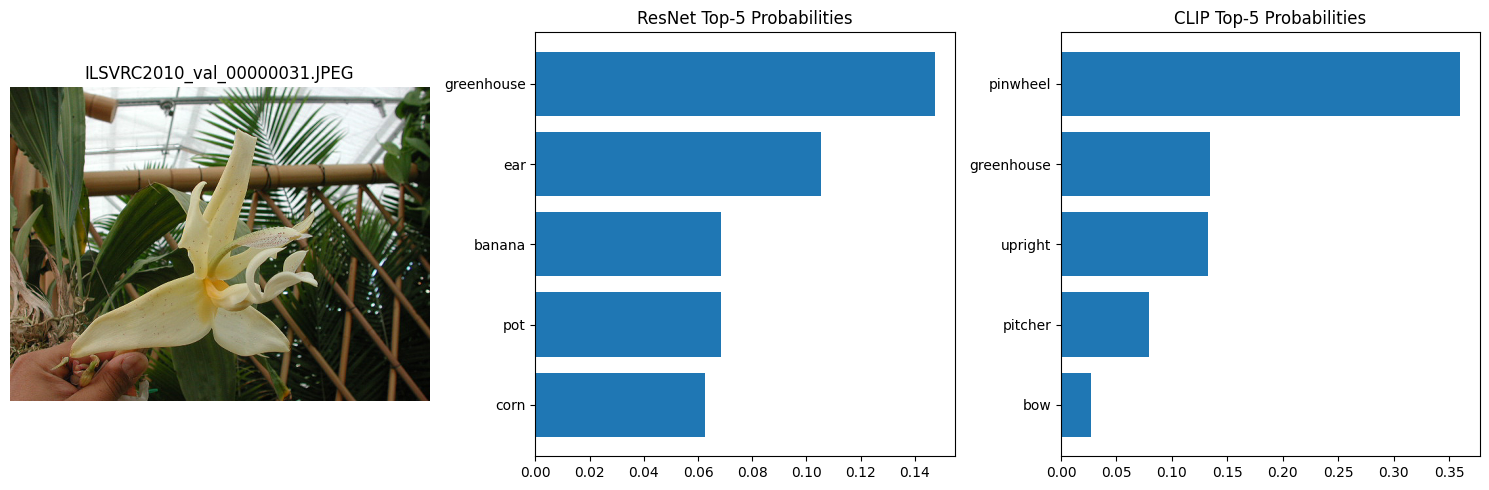

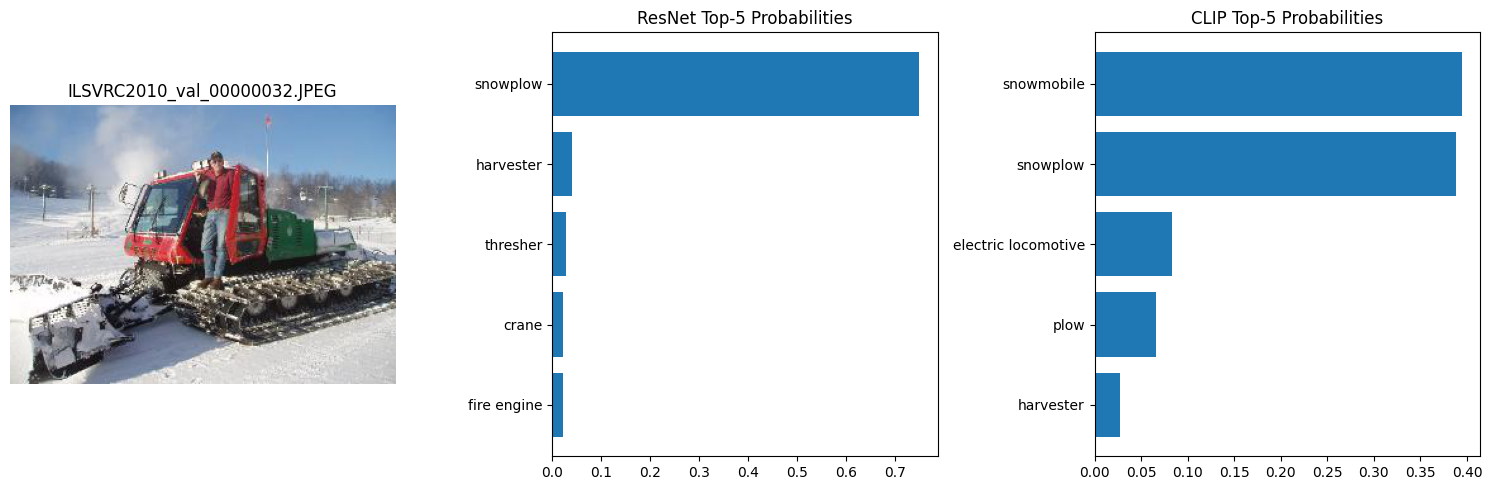

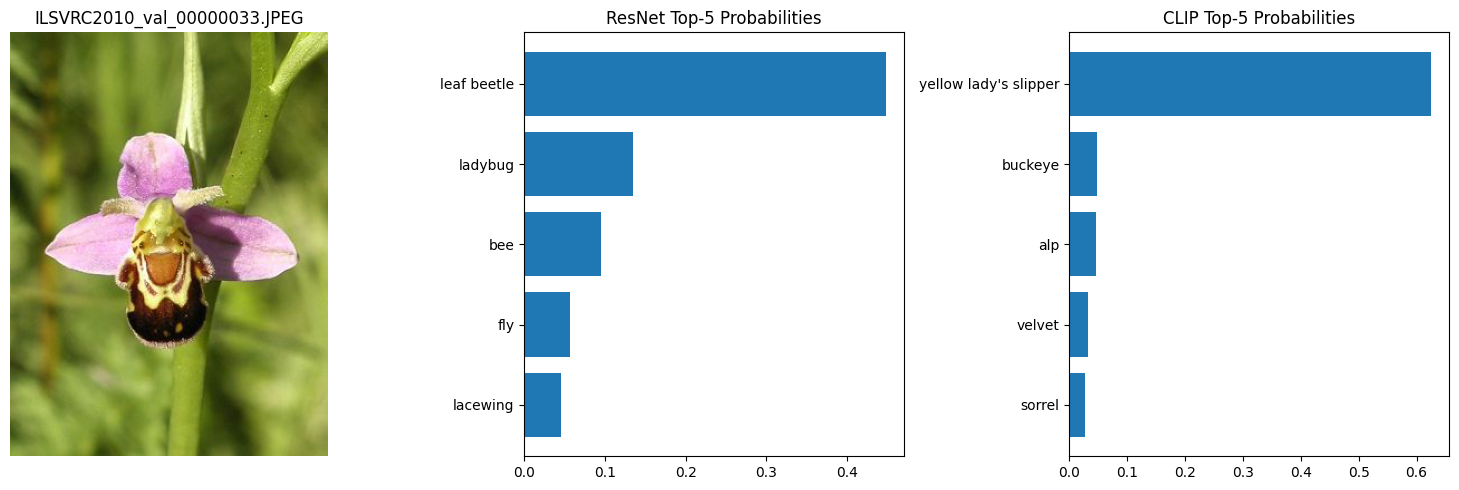

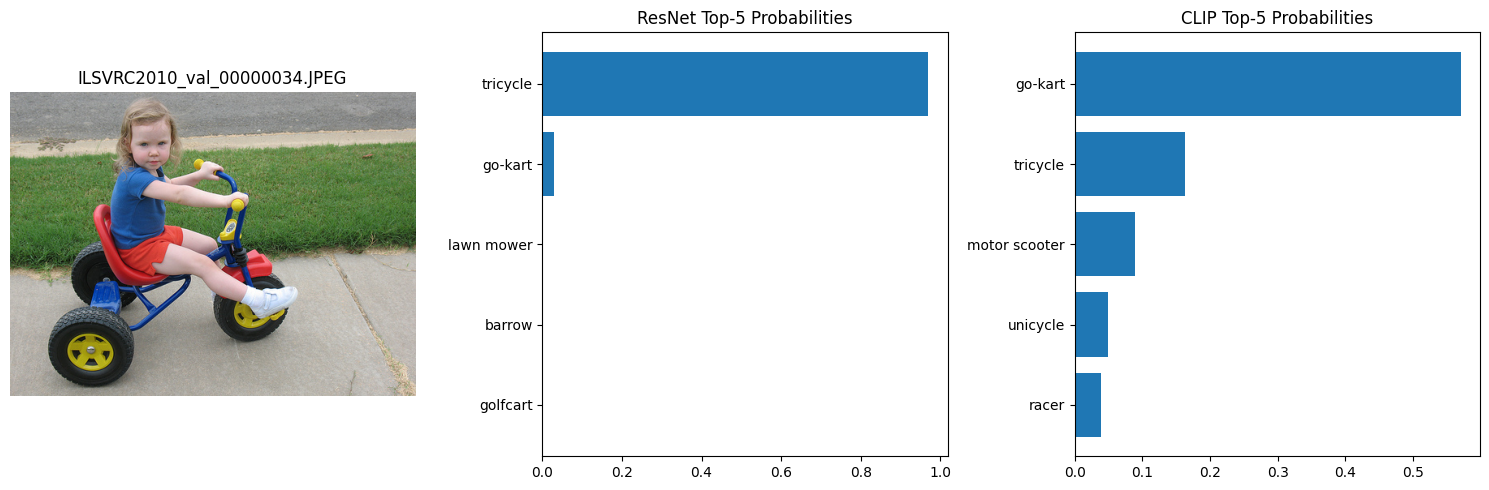

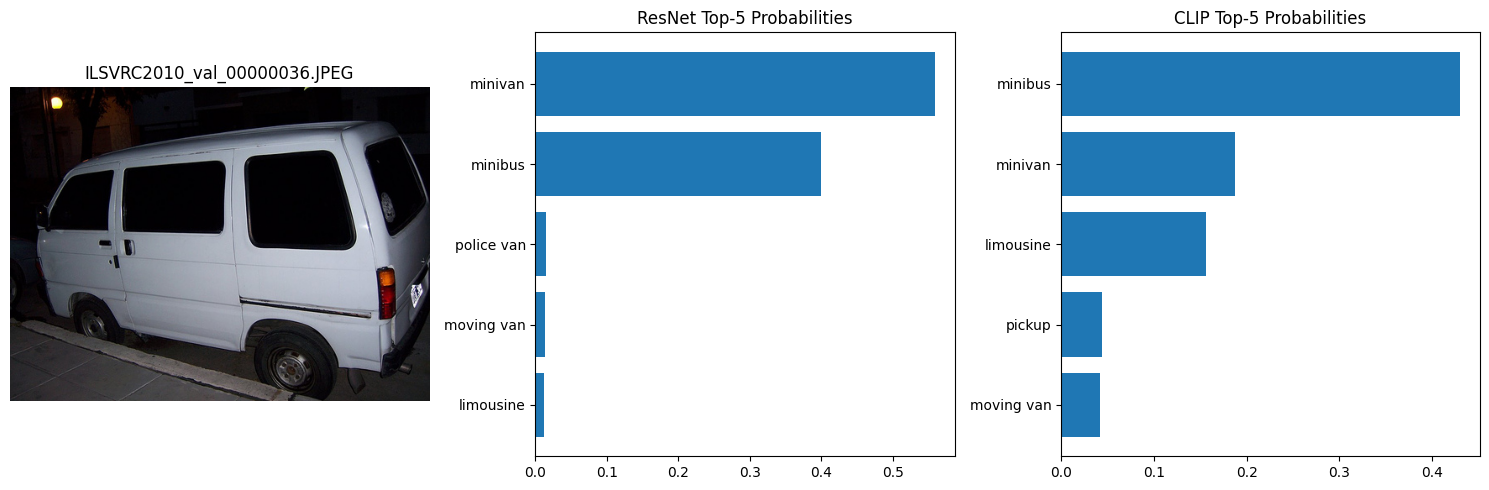

In [18]:
val_paths = sorted(demo_dir.glob("*.JPEG"))
num = 0
for img_path in val_paths:
    img_tensor = preprocess(Image.open(img_path).convert("RGB")) \
                    .unsqueeze(0).to(device)
    r_inds, r_vals = get_topk(resnet50, img_tensor)
    c_inds, c_vals = get_topk(
        clip_model.encode_image,
        img_tensor,
        text_feats= text_features,
        logit_scale= clip_model.logit_scale
    )
    if r_inds[0] != c_inds[0]:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(Image.open(img_path))
        axs[0].axis('off')
        axs[0].set_title(img_path.name)
        axs[1].barh(range(len(r_vals)), r_vals)
        axs[1].invert_yaxis()
        axs[1].set_yticks(range(len(r_inds)))
        axs[1].set_yticklabels([labels[i] for i in r_inds])
        axs[1].set_title("ResNet Top-5 Probabilities")
        axs[2].barh(range(len(c_vals)), c_vals)
        axs[2].invert_yaxis()
        axs[2].set_yticks(range(len(c_inds)))
        axs[2].set_yticklabels([labels[i] for i in c_inds])
        axs[2].set_title("CLIP Top-5 Probabilities")
        plt.tight_layout()
        plt.show()
        num += 1
        if num >= 20:
            break

### Find 2 images where CLIP works well but ImageNet RN50 fails

#### Image 1: `ILSVRC2010_val_00000004.JPEG`
- **Image**: A person behind a metallic object that looks like a kitchen appliance.
- **CLIP Prediction**: `measuring cup` (Correct context: kitchen equipment)
- **ResNet Prediction**: `scale` (Misleading, as it seems to have misinterpreted the object)

**Reason**: CLIP has been trained with natural language supervision on diverse image-text pairs, allowing it to understand **contextual cues** like people in kitchens or baristas. ImageNet RN50, trained only to classify cropped objects in isolation, lacks this scene-level understanding.

---

#### Image 2: `ILSVRC2010_val_00000010.JPEG`
- **Image**: A plate of grilled seafood, possibly shrimp or skewered meat.
- **CLIP Prediction**: `rotisserie`, `American lobster`, `Dungeness crab` (General recognition of grilled seafood)
- **ResNet Prediction**: `bagel` (Completely off — focused on circular shapes?)

**Reason**: CLIP uses holistic understanding of the image and text alignment. Since its supervision involves diverse food captions and labels (e.g., "A plate of grilled shrimp"), it's more robust to **real-world meal presentation**. ResNet likely focused on local texture/shape, confusing circular food for a bagel.

---

### Find 1 image where ImageNet pretraining works well but CLIP fails

#### Image: `ILSVRC2010_val_00000007.JPEG`
- **Image**: A detailed close-up of an insect on a flower.
- **ResNet Prediction**: `mantis`, `monarch`, `sulphur butterfly` (Correct guesses within the insect category)
- **CLIP Prediction**: `yellow lady’s slipper`, `garden spider`, `pitcher` (Focused on plant and flower terms)

**Reason**: ImageNet RN50 excels at **fine-grained classification of objects like insects**, as it has been trained on thousands of such labeled examples. CLIP's reliance on language-text alignment can sometimes **bias it toward prominent non-object entities** (like the flower in this case), especially when the insect isn't the most salient object by size or color.

---

### Image Source

All images are taken from the **ILSVRC2010 ImageNet validation set** and were visualized during evaluation using:
val_paths = sorted(demo_dir.glob("*.JPEG"))

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
orig_model = clip_visual

def quantize_model(orig_model, bits):
    m = copy.deepcopy(orig_model).to(torch.float32)
    for p in m.parameters():
        data = p.data
        mx   = data.abs().max()
        scale = mx / (2**(bits - 1) - 1) if mx > 0 else 1.0
        p.data = (data / scale).round().clamp(
            -(2**(bits - 1)), 2**(bits - 1) - 1
        ) * scale
    return m

configs = [
    {"name": "FP32", "model": orig_model,               "dtype": torch.float32, "use_amp": False},
    {"name": "FP16", "model": orig_model.half(),        "dtype": torch.float16, "use_amp": True },
    {"name": "FP8",  "model": quantize_model(orig_model, 8),  "dtype": torch.float32, "use_amp": False},
    {"name": "FP4",  "model": quantize_model(orig_model, 4),  "dtype": torch.float32, "use_amp": False},
]

inp_cpu = batch[0:1] if 'batch' in locals() else torch.randn(1, 3, 224, 224)
results = {}
for cfg in configs:
    name, model, dtype, use_amp = cfg.values()
    model = model.to(device).eval()
    inp   = inp_cpu.to(device).to(dtype)
    with torch.no_grad():
        for _ in range(5):
            with autocast("cuda", enabled=use_amp):
                _ = model(inp)
    times, mems = [], []
    for _ in range(100):
        torch.cuda.reset_peak_memory_stats(device)
        start = time.time()
        with torch.no_grad(), autocast("cuda", enabled=use_amp):
            _ = model(inp)
        if device.type == "cuda":
            torch.cuda.synchronize()
        times.append((time.time() - start) * 1e3)
        mems.append(torch.cuda.max_memory_allocated(device) / 1024**2)
    t_mean, t_std = torch.tensor(times).mean().item(), torch.tensor(times).std().item()
    m_mean, m_std = torch.tensor(mems).mean().item(), torch.tensor(mems).std().item()
    results[name] = (t_mean, t_std, m_mean, m_std)

for name in ["FP32","FP16","FP8","FP4"]:
    t_mean, t_std, m_mean, m_std = results[name]
    print(f"{name}: {t_mean:.1f}±{t_std:.1f} ms | Mem: {m_mean:.1f}±{m_std:.1f} MiB")

FP32: 8.5±0.2 ms | Mem: 675.2±0.0 MiB
FP16: 8.8±0.6 ms | Mem: 675.5±0.0 MiB
FP8: 7.6±0.3 ms | Mem: 693.6±0.0 MiB
FP4: 7.5±0.3 ms | Mem: 693.6±0.0 MiB


In [22]:
subset_imgs = batch[:5]  
fp32_model = clip_visual.to(torch.float32).eval().to(device)
fp16_model = clip_visual.half().eval().to(device)
for i, x in enumerate(subset_imgs):
    x = x.unsqueeze(0).to(device)
    with torch.no_grad():
        out_fp32 = fp32_model(x.to(torch.float32)).softmax(dim=-1)
        with autocast(device_type="cuda", enabled=True):
            out_fp16 = fp16_model(x.to(torch.float16)).softmax(dim=-1)
    abs_diff = (out_fp32 - out_fp16).abs()
    print(f"Image {i+1}: L1 diff = {abs_diff.sum():.4f}, Max diff = {abs_diff.max():.4f}")


inp = batch[0:1].to(device)  
def run_once(model, dtype, use_amp):
    torch.cuda.reset_peak_memory_stats()
    model = model.eval().to(device)
    x = inp.to(dtype)
    with torch.no_grad():
        with autocast("cuda", enabled=use_amp):
            _ = model(x)
    mem = torch.cuda.max_memory_allocated(device) / 1024**2
    return mem

mem_fp32 = run_once(clip_visual.to(torch.float32), torch.float32, False)
mem_fp16 = run_once(clip_visual.half(), torch.float16, True)
print(f"FP32 Memory: {mem_fp32:.1f} MiB")
print(f"FP16 Memory: {mem_fp16:.1f} MiB")

Image 1: L1 diff = 0.0002, Max diff = 0.0000
Image 2: L1 diff = 0.0002, Max diff = 0.0000
Image 3: L1 diff = 0.0002, Max diff = 0.0000
Image 4: L1 diff = 0.0002, Max diff = 0.0000
Image 5: L1 diff = 0.0002, Max diff = 0.0000
FP32 Memory: 766.2 MiB
FP16 Memory: 675.9 MiB


---

### Quantization and Precision Experiment Summary on CLIP Visual Encoder

This experiment evaluates the **runtime performance**, **memory usage**, and **output consistency** of the CLIP visual encoder under various numerical precisions: FP32, FP16, FP8, and FP4.

---

### Inference Time & Memory Usage

| Precision | Time (ms)      | Std Dev (ms) | Memory (MiB) | Std Dev (MiB) |
|-----------|----------------|--------------|---------------|----------------|
| **FP32**  | 8.5            | ±0.2         | 675.2         | ±0.0           |
| **FP16**  | 8.8            | ±0.6         | 675.5         | ±0.0           |
| **FP8**   | 7.6            | ±0.3         | 693.6         | ±0.0           |
| **FP4**   | 7.5            | ±0.3         | 693.6         | ±0.0           |

**Observations**:
- Lower precision (FP8/FP4) slightly reduces runtime (~11% faster than FP32).
- Surprisingly, **memory usage increases** for FP8/FP4 due to storage in `float32` post quantization (no real compression benefit).
- FP16 provides **moderate savings** in memory (≈ 90 MiB less than FP32).

---

### Output Consistency: FP32 vs FP16

Comparison across 5 sample images:

| Image | L1 Difference | Max Difference |
|-------|---------------|----------------|
| 1     | 0.0002        | 0.0000         |
| 2     | 0.0002        | 0.0000         |
| 3     | 0.0002        | 0.0000         |
| 4     | 0.0002        | 0.0000         |
| 5     | 0.0002        | 0.0000         |

**Observation**:
- Very small numerical difference between FP32 and FP16 outputs, confirming **high fidelity** with reduced precision.
- Max difference is essentially **zero**, supporting safe deployment of FP16 for inference.

---

### One-shot Memory Profiling

| Precision | Memory Usage |
|-----------|----------------|
| FP32      | 766.2 MiB      |
| FP16      | 675.9 MiB      |

**Conclusion**:
- FP16 offers a **~12% memory reduction** over FP32.
- Combined with almost identical output, FP16 is a **practical drop-in** replacement for inference.
- While FP8/FP4 offer faster runtime, they don’t yield memory benefits here due to implementation (still stored as float32).

---